In [2]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as patches
import warnings
import numpy as np
warnings.filterwarnings('ignore')

from time import time

# Loading the data
playlist = pd.read_csv('./PlayList.csv')
injury_rec = pd.read_csv('InjuryRecord.csv')
player_track = pd.read_csv('PlayerTrackData.csv', nrows=int(1e6)) # loading only a small portion of the data

In [3]:
# Splitting data between synthetic and natural fields
injury_nat = injury_rec[injury_rec.Surface == 'Natural']
injury_synth = injury_rec[injury_rec.Surface == 'Synthetic']

In [4]:
# Merging datasets
injury_nat_play = pd.merge(injury_nat,
                 playlist,
                 on = ['PlayerKey', 'GameID', 'PlayKey'],
                       how = 'left')
injury_synth_play = pd.merge(injury_synth,
                 playlist,
                 on = ['PlayerKey', 'GameID', 'PlayKey'],
                       how = 'left')

injury_play = pd.merge(injury_rec,
                 playlist,
                 on = ['PlayerKey', 'GameID', 'PlayKey'],
                       how = 'left')

inj_play_enc = pd.concat([injury_play,pd.get_dummies(injury_play['BodyPart'], prefix = 'part'), pd.get_dummies(injury_play['RosterPosition'], prefix='pos')],axis=1)

injury_play.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,Linebacker,29.0,4.0,Indoors,Synthetic,84.0,Cloudy,Punt,32.0,OLB,LB
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,Linebacker,50.0,7.0,Open,Natural,76.0,Partly Cloudy,Punt,26.0,OLB,LB
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,Safety,1.0,1.0,Outdoor,Synthetic,63.0,Clear and warm,Pass,70.0,SS,DB
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,Linebacker,15.0,3.0,Outdoor,Natural,80.0,Cloudy,Punt,30.0,LB,LB
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,Wide Receiver,32.0,5.0,Retractable Roof,Synthetic,89.0,Partly Cloudy,Kickoff,69.0,WR,WR


In [5]:
# Merging knee, foot, and ankle injuries
# All values in these columns will now be equal to 0 or 1
# One hot encoding for feature engineering
m_injury_play = pd.merge(playlist, injury_rec, on = 'PlayKey',how = 'left')
m_injury_play['Injury'] = m_injury_play['BodyPart'].apply(lambda x: 1 if x in ['Knee', 'Foot', 'Ankle']  else 0)

m_injury_play_agg = m_injury_play[['StadiumType', 'FieldType', 'Weather', 'Injury', 'PlayType', 'Position', 'PlayerDay', 'Temperature']]

# Changing weather, stadium type, and field type to a value of either 0 or 1
# One hot encoding for feature engineering
m_injury_play_agg['Weather'] = m_injury_play_agg.Weather.isin(['rain', 'Rain', 'Snow', 'snow'])
m_injury_play_agg['Weather'] = m_injury_play_agg['Weather'].apply(lambda x: 1 if x == True  else 0)

m_injury_play_agg['StadiumType'] = m_injury_play_agg.StadiumType.isin(['Outdoor', 'Outdoors', 'Open', 'Oudoor', 'Ourdoor', 'Outddors', 'Outdor', 'Outside'])
m_injury_play_agg['StadiumType'] = m_injury_play_agg['StadiumType'].apply(lambda x: 1 if x == True  else 0)

m_injury_play_agg['FieldType'] = m_injury_play_agg.FieldType.isin(['Natural'])
m_injury_play_agg['FieldType'] = m_injury_play_agg['FieldType'].apply(lambda x: 1 if x == True  else 0)

m_injury_play_agg.PlayType = pd.Categorical(m_injury_play_agg.PlayType)
m_injury_play_agg['PlayType_c'] = m_injury_play_agg.PlayType.cat.codes

m_injury_play_agg.Position = pd.Categorical(m_injury_play_agg.Position)
m_injury_play_agg['Position_c'] = m_injury_play_agg.Position.cat.codes

# Multiplying stadium type variable with weather variable
# Games that are played indoors are not affected by weather
m_injury_play_agg['Multiplication'] = m_injury_play_agg['StadiumType'] * m_injury_play_agg['Weather']

In [6]:
m_injury_play_agg.head()

,StadiumType,FieldType,Weather,Injury,PlayType,Position,PlayerDay,Temperature,PlayType_c,Position_c,Multiplication
0,1,0,0,0,Pass,QB,1,63,6,16,0
1,1,0,0,0,Pass,QB,1,63,6,16,0
2,1,0,0,0,Rush,QB,1,63,10,16,0
3,1,0,0,0,Rush,QB,1,63,10,16,0
4,1,0,0,0,Pass,QB,1,63,6,16,0


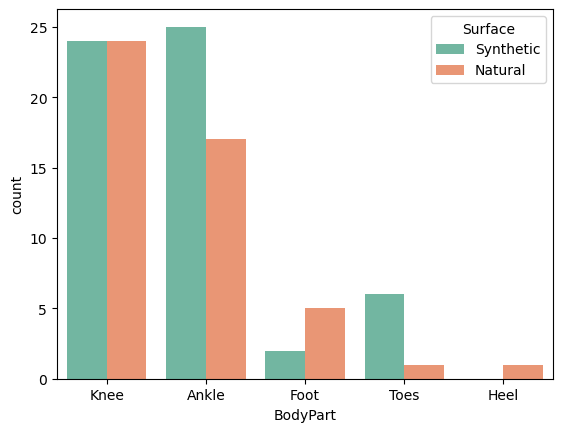

In [11]:
# Comparing injuries based on body part
# Knee and ankle injuries tend to have increased severity
import seaborn as sns

sns.countplot(data = injury_play, x = 'BodyPart', hue = 'Surface', palette = 'Set2')
plt.show()

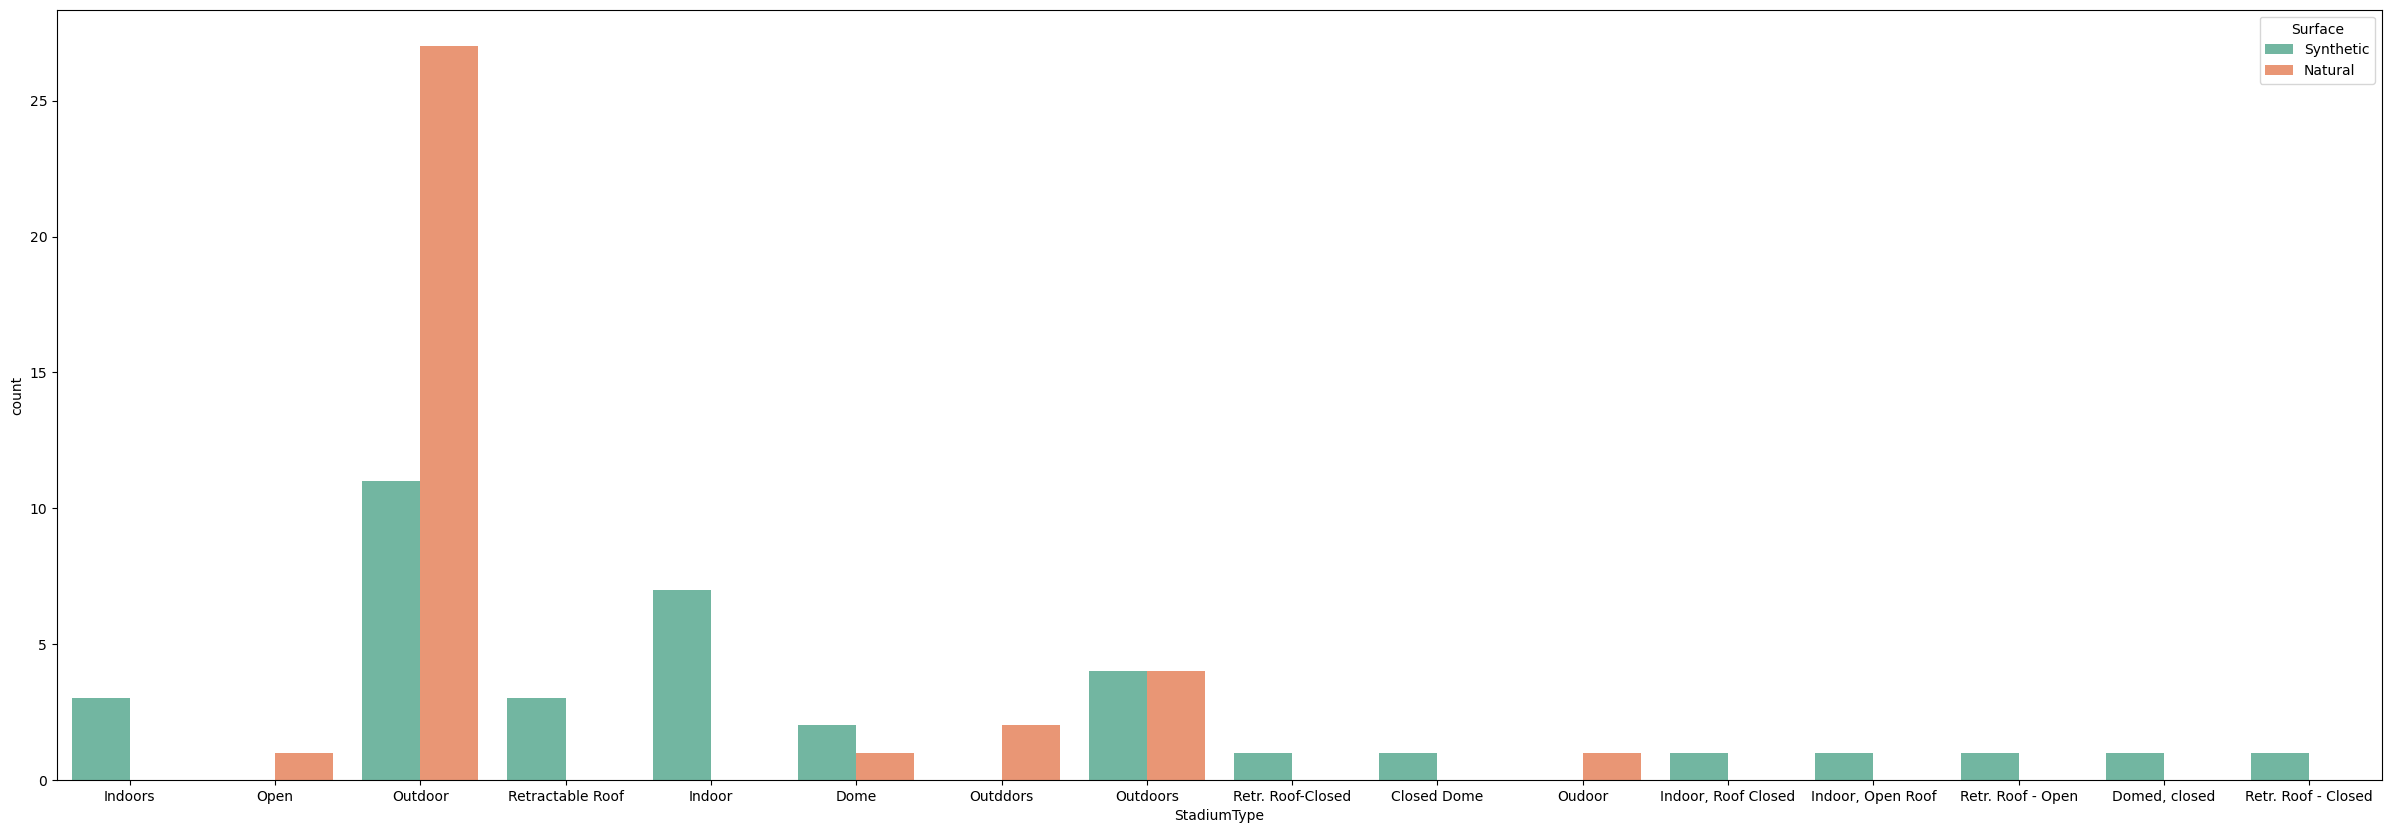

In [8]:
# Comparing injuries based on stadium type
plt.figure(figsize = (30, 10))
sns.countplot(data = injury_play, x = 'StadiumType', hue = 'Surface', palette = 'Set2')
plt.show()

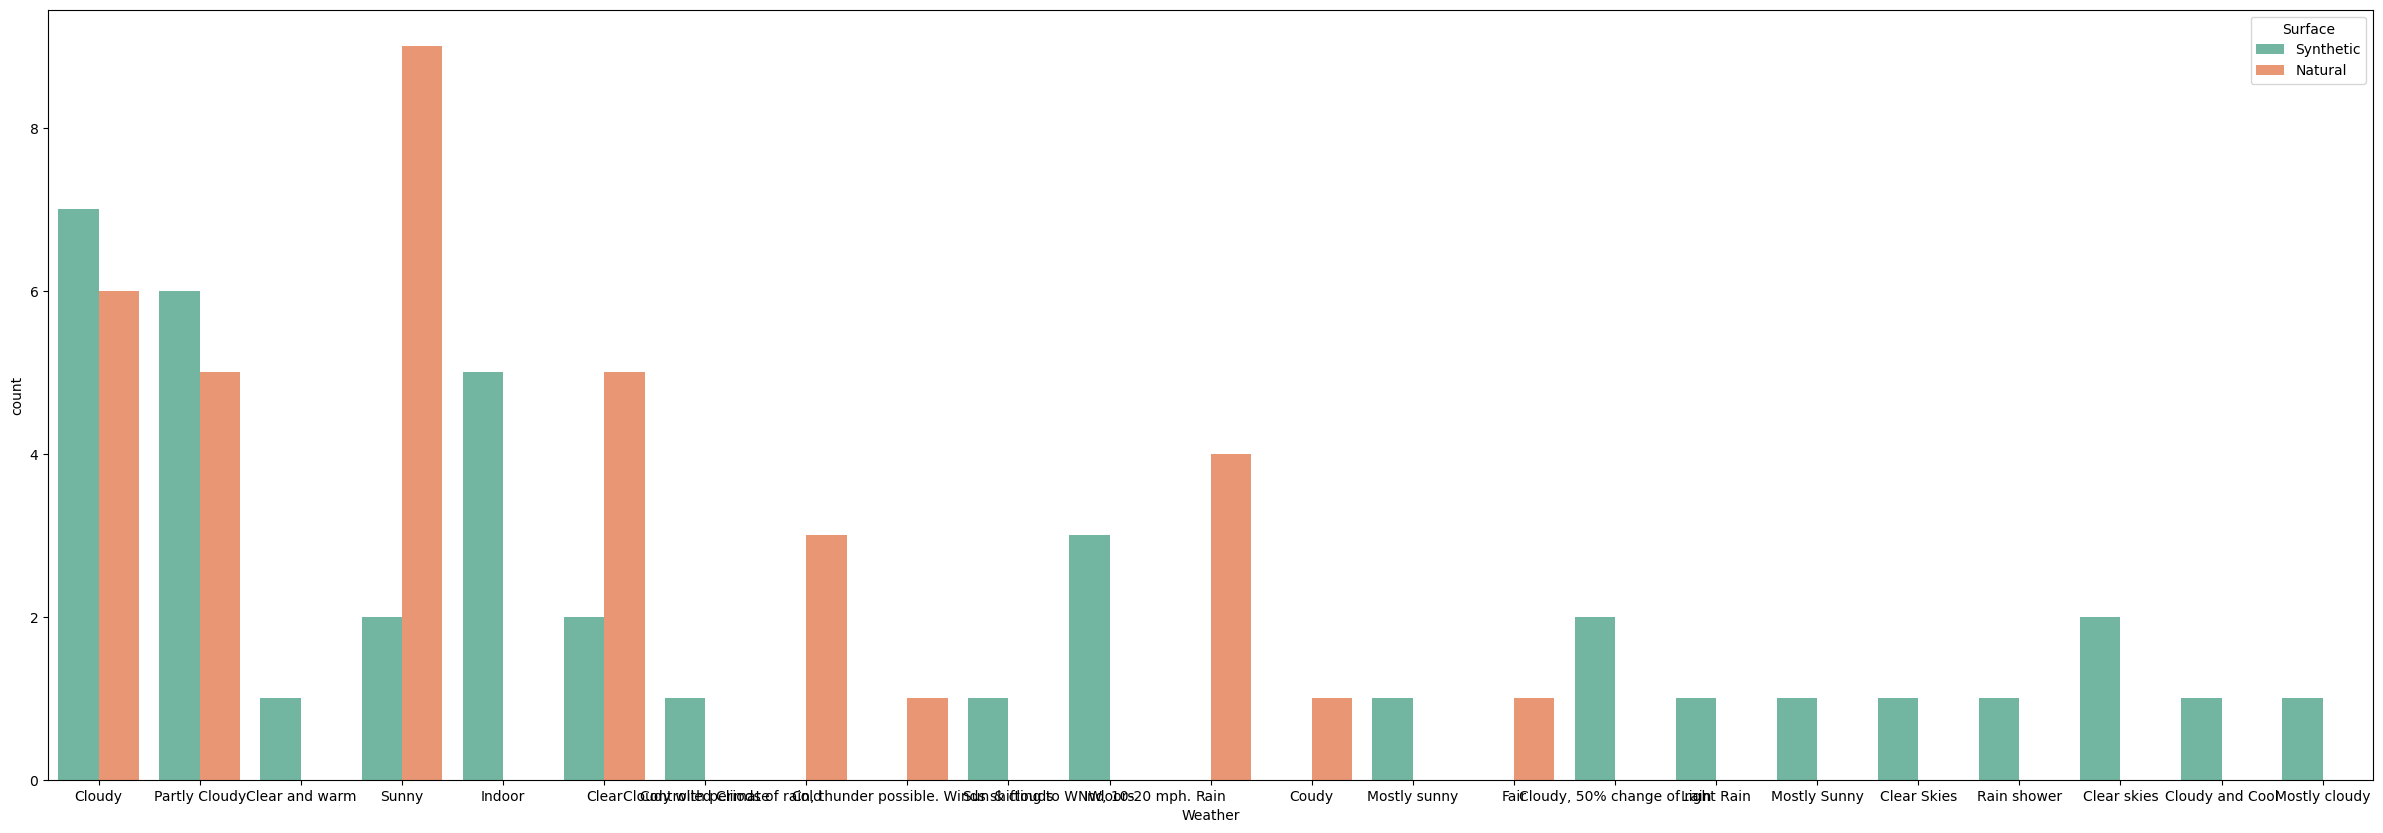

In [9]:
# Comparing injuries based on weather
plt.figure(figsize = (30, 10))
sns.countplot(data = injury_play, x = 'Weather', hue = 'Surface', palette = 'Set2')
plt.show()

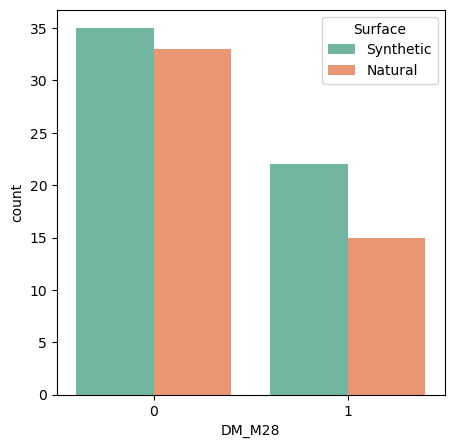

In [10]:
# Comparing injuries based on injury length (at least 28 days missed due to injury)
# Injury length is proportional to injury severity

plt.figure(figsize = (5, 5))
sns.countplot(data = injury_play, x = 'DM_M28', hue = 'Surface', palette = 'Set2')
plt.show()

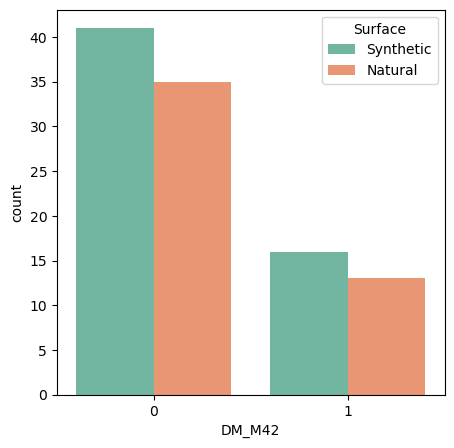

In [12]:
# Comparing injuries based on injury length (at least 42 days missed due to injury)
# Injury length is proportional to injury severity

plt.figure(figsize = (5, 5))
sns.countplot(data = injury_play, x = 'DM_M42', hue = 'Surface', palette = 'Set2')
plt.show()

In [13]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Adding predictor variables and target variable
data = m_injury_play_agg
X = data[['StadiumType', 'Weather', 'FieldType']]
y = data['Injury']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 16)

# Training a random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Making predictions on test data
y_pred = model.predict(X_test)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'weighted')
print("F1 Score:", f1)

Accuracy: 0.9998127387580834
Precision: 0.0
Recall: 0.0
F1 Score: 0.9997191169046392


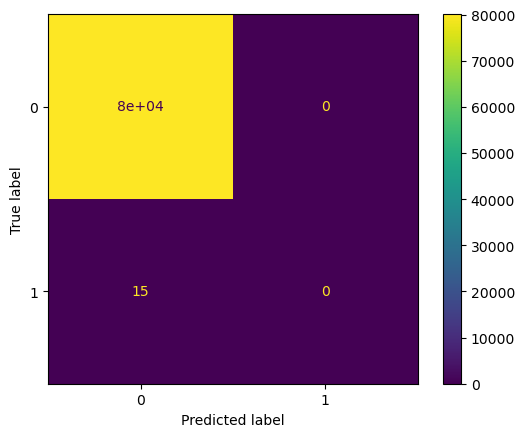

In [14]:
# Importing libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Creating and fitting the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Making predictions on the test data
y_pred = model.predict(X_test)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [15]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Adding predictor variables and target variable
data = m_injury_play_agg
X = data[['StadiumType', 'Weather', 'FieldType']]
y = data['Injury']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

# Training logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Making predictions on the test data
y_pred = model.predict(X_test)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'weighted')
print("F1 Score:", f1)

Accuracy: 0.9998127387580834
Precision: 0.0
Recall: 0.0
F1 Score: 0.9997191169046392


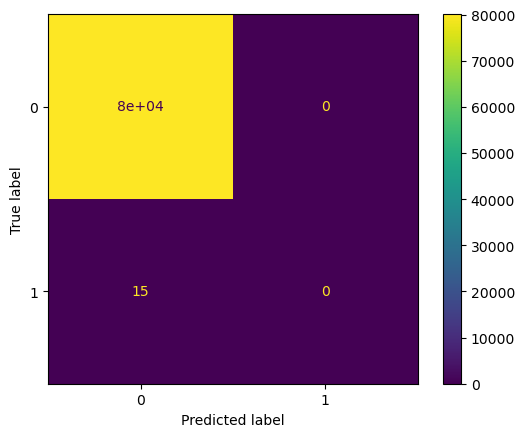

In [16]:
# Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Creating and fitting the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Making predictions on the test data
y_pred = model.predict(X_test)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [17]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Adding predictor variables and target variable
data = m_injury_play_agg
X = data[['StadiumType', 'Weather', 'FieldType']]
y = data['Injury']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

# Creating a decision tree classifier
model = DecisionTreeClassifier() 
model.fit(X_train, y_train) 

# Make predictions on the test data
y_pred = model.predict(X_test) 

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'weighted')
print("F1 Score:", f1)

Accuracy: 0.9998127387580834
Precision: 0.0
Recall: 0.0
F1 Score: 0.9997191169046392


In [18]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# Adding predictor variables and target variable
data = m_injury_play_agg
X = data[['StadiumType', 'Weather', 'FieldType']]
y = data['Injury']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

# Creating an SVM classifier
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Making predictions on the test data
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'weighted')
print("F1 Score:", f1)

kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa:", kappa)

Accuracy: 0.9998127387580834
Precision: 0.0
Recall: 0.0
F1 Score: 0.9997191169046392
Kappa: 0.0


In [19]:
m_injury_play_agg['Injury'].value_counts()

Injury
0    266929
1        77
Name: count, dtype: int64

In [20]:
# Importing libraries
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as patches
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from time import time

# Loading dataset
injury_rec = pd.read_csv('InjuryRecord.csv')

In [21]:
# Removing unnecessary columns
del injury_rec['PlayerKey']

In [22]:
del injury_rec['GameID']

In [23]:
del injury_rec['PlayKey']
injury_rec.head()

,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,Knee,Synthetic,1,1,1,1
1,Knee,Natural,1,1,0,0
2,Ankle,Synthetic,1,1,1,1
3,Ankle,Natural,1,0,0,0
4,Ankle,Synthetic,1,1,1,1


In [24]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Adding predictor variables and target variable
data = injury_rec
X = data[['DM_M7', 'DM_M28', 'DM_M42']]
y = data['Surface']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 16)

# Training a random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Making predictions on test data
y_pred = model.predict(X_test)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred, average = "binary", pos_label = "Synthetic")
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'weighted')
print("F1 Score:", f1)

recall = recall_score(y_test, y_pred, pos_label = "Synthetic")
print("Recall:", recall)

Accuracy: 0.5238095238095238
Precision: 0.6153846153846154
F1 Score: 0.5238095238095238
Recall: 0.6153846153846154


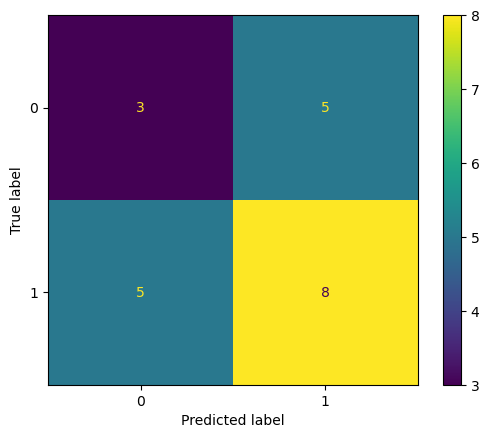

In [25]:
# Importing libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Creating and fitting the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Making predictions on the test data
y_pred = model.predict(X_test)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [26]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Adding predictor variables and target variable
data = injury_rec
X = data[['DM_M7', 'DM_M28', 'DM_M42']]
y = data['Surface']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 16)

# Training for logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Making predictions on test data
y_pred = model.predict(X_test)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred, average = "binary", pos_label = "Synthetic")
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'weighted')
print("F1 Score:", f1)

recall = recall_score(y_test, y_pred, pos_label = "Synthetic")
print("Recall:", recall)

Accuracy: 0.5238095238095238
Precision: 0.6153846153846154
F1 Score: 0.5238095238095238
Recall: 0.6153846153846154
